In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-darkgrid')
from pandas.plotting import register_matplotlib_converters
import datetime
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import json
from tqdm import tqdm
tqdm.pandas()

register_matplotlib_converters()

# making the json input file for fever/coronavirus

In [174]:
columns = ['description.comments', 'target', 'description.event_opened', 'NFPA.type', 'fire_department.firecares_id']
columbus=pd.read_pickle('columbus'+'_by_incident')
columbus['target'] = columbus['description.subtype'] == 'CE'

columbus = columbus[columns]

miami=pd.read_pickle('miami'+'_by_incident')
miami['target'] = (miami['description.type']== 'SICK PERS - FEVER -') | (miami['description.type'] == 'FEVER WITH TRAVEL')
miami = miami[columns]
miami['description.event_opened'] = pd.to_datetime(miami['description.event_opened'])

In [175]:
df = pd.concat([columbus, miami])

#Extract year, month, and day from all timestamps
df['date'] = df['description.event_opened'].apply(lambda x: x.strftime('%Y-%m-%d'))

#Convert to datetime
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'] >= pd.to_datetime('03-15-2020')].reset_index(drop=True)
df = df[(df['NFPA.type']=='EMS') | (df['NFPA.type']=='OTHER')].reset_index(drop=True)



In [178]:
json_data = {}
json_data['name'] = 'coronavirus_symptoms'
json_data['data'] = df[['fire_department.firecares_id','description.comments', 'target']].to_dict(orient='records') 
with open('coronavirus_symptoms.json', 'w') as outfile:
    json.dump(json_data, outfile)

# Fitting a word vectorizer to both departments and then looking at the intersection

In [121]:
count_vect_columb = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, 
                     stop_words='english', min_df=20,ngram_range=(1,2))

count_vect_columb.fit(columbus['description.comments'])

count_vect_miami = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, 
                     stop_words='english', min_df=20,ngram_range=(1,2))

count_vect_miami.fit(miami['description.comments'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=20,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?ui)\\b\\w*[a-z]+\\w*\\b',
        tokenizer=None, vocabulary=None)

In [122]:
columb_words = set(count_vect_columb.get_feature_names())
miami_words = set(count_vect_miami.get_feature_names())

In [111]:
columb_words & miami_words

{'op',
 'blu pants',
 'o2',
 '19th',
 'pepper',
 'dk',
 'obvious',
 'pain body',
 'healthcare',
 'smoke det',
 'veh blk',
 'kia',
 '1st fl',
 'aneurysm',
 'week ago',
 'got',
 'stroke cva',
 'answered',
 'fell hit',
 'alert breathing',
 'unknown unknown',
 'medicine',
 'intoxicated',
 'lockbox code',
 'tumor',
 'passing',
 '18c02',
 'constipated',
 'heavyset',
 'stroke',
 'ambulance',
 'sugar',
 'skin',
 'asst',
 'hallway',
 'touch',
 'meters',
 'yo',
 'event',
 'shorts',
 'gate code',
 'danielle',
 'custody',
 'ford fusion',
 'heart beating',
 'pain lower',
 'sweating',
 'lee',
 'sidewalk ifo',
 'thompson',
 'male fell',
 'getting worse',
 'ranger',
 '13c02',
 'statement dislocated',
 'hrs ago',
 'tim',
 'tell',
 'hazard',
 'voice',
 'loss balance',
 'male ground',
 'wearing red',
 'enr',
 'ff',
 'mr',
 '26a02',
 'roadway',
 'busted',
 'coa',
 'veh smoking',
 'vaginal bleeding',
 'unknown multiple',
 '24d04',
 'seizure alert',
 'mother',
 'abnormal',
 'assist injuries',
 'loc',
 'inv'

In [144]:
columbus['description.comments'].iloc[49]

'88 Y/O FEMALE / FELL YESTERDAY HAVING LEG PAIN / PT HAS HIP AND LEG ISSUES DAUGHTER SAID IS VERY FRAGILE ((( GO IN THRU GARAGE ))) ** LOI search completed at 07/14/19 09:04:05 ** Recommended unit M29 for requirement MEDIC (2.8 mi)'

In [145]:
miami['description.comments'].iloc[90]

'Incident Initiated By: FD/PERSON,SHANNON;4 VEHS INV;E54 NOT INV;STILLASSESSING. STANDBY REF INJ;BLK JEEP WRANGLER;BLK HONDA 4 DOOR;GOLD CHEVY SUV;SIL HYUNDAI;FHP HOLDING FOR NEXT AVAIL;PULLED VEH INTO 151ST ST;Incident Closed: 20/01/01 03:51'

In [118]:
len(count_vect_miami.get_feature_names())

15148

In [73]:
df = pd.concat([columbus, miami])


df['description.event_opened'] = pd.to_datetime(df['description.event_opened'], utc=True)

#Extract year, month, and day from all timestamps
df['date'] = df['description.event_opened'].apply(lambda x: x.strftime('%Y-%m-%d'))

#Convert to datetime
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'] > pd.to_datetime('03-15-2020')].reset_index()


In [81]:
ems_df = df[(df['NFPA.type']=='EMS') | (df['NFPA.type']=='OTHER')]

# stemmer = SnowballStemmer('english')
# ems_df['stemmed_comments'] = ems_df['description.comments'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(' ')]))

count_vect = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, 
                     stop_words='english', min_df=20,ngram_range=(1,2))
comment_df = ems_df['description.comments']

X_train, X_test, y_train, y_test = train_test_split(comment_df, 
                                                    ems_df['covid'], test_size=0.2, 
                                                    random_state=3, stratify=ems_df['covid'])

X_train_cv = count_vect.fit_transform(X_train)
X_test_cv = count_vect.transform(X_test)

In [97]:
count_vect.get_feature_names()

['01a01',
 '01a01 year',
 '05a01',
 '05a01 year',
 '06c01',
 '06c01 dispatch',
 '06c01 year',
 '06d01',
 '06d01 year',
 '06d02',
 '06d02 year',
 '06d04',
 '06d04 year',
 '07d',
 '09e01',
 '09e01 year',
 '107th',
 '10a01',
 '10a01 entered',
 '10a01 year',
 '10a1',
 '10a1 incident',
 '10c01',
 '10c01 entered',
 '10c01 year',
 '10c02',
 '10c02 year',
 '10c03',
 '10c03 entered',
 '10c04',
 '10c04 year',
 '10c1',
 '10c1 incident',
 '10c1 loc',
 '10c1 proqa',
 '10c3',
 '10c3 incident',
 '10c3 loc',
 '10c3 proqa',
 '10d01',
 '10d01 entered',
 '10d02',
 '10d02 entered',
 '10d02 year',
 '10d04',
 '10d04 entered',
 '10d04 year',
 '10d05',
 '10d05 entered',
 '10d1',
 '10d2',
 '10d2 loc',
 '10d2 proqa',
 '10d4',
 '10d4 incident',
 '10d4 loc',
 '10d4 proqa',
 '10d5',
 '10d5 incident',
 '10d5 loc',
 '10d5 proqa',
 '10ft',
 '10ft 3m',
 '10th',
 '112th',
 '117th',
 '11th',
 '12a01',
 '12a01 dispatch',
 '12a01e',
 '12a01e entered',
 '12a02',
 '12a02 year',
 '12a1e',
 '12a1e diagnosis',
 '12b01',
 '12b0

In [ ]:
miami['description.comments']

0.9025763951507865


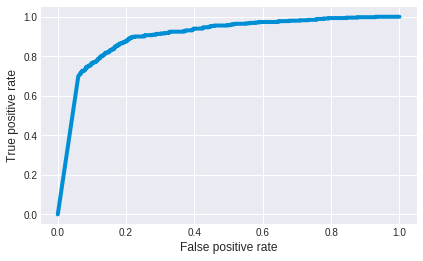

In [82]:
model = MultinomialNB(alpha=1)
model.fit(X_train_cv, y_train)
y_score = model.predict_proba(X_test_cv)
decision_threshold = 0.99
predictions = y_score[:,1] >= decision_threshold
print(roc_auc_score(y_test, y_score[:,1]))

cm = confusion_matrix(y_test, predictions)
# sns.heatmap(cm/len(predictions)*100, square=True, annot=True, cmap=plt.cm.coolwarm, cbar=False,
# xticklabels=['no exposure', 'exposure'], yticklabels=['no exposure', 'exposure'])
# plt.xlabel('predicted label')
# plt.ylabel('true label')

plt.style.use('seaborn-darkgrid')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('roc_curve')

In [80]:
likelihood_ratio = model.feature_log_prob_[0, :] - model.feature_log_prob_[1, :]
biggest = likelihood_ratio.argsort()
smallest = np.flip(likelihood_ratio.argsort())
print("The keywords that most strongly indicate CE \n")
print(np.take(count_vect.get_feature_names(), biggest[:100]))
print("\n The keywords that most strongly indicate not CE \n")
print(np.take(count_vect.get_feature_names(), smallest[:100]))

The keywords that most strongly indicate CE 

['26a4 proqa' 'code fever' '26a4' 'type 26a4' 'alias 26a04'
 '26a04 entered' 'ill ce' 'db ce' 'ce event' 'updated recommended'
 'level updated' '26a4 incident' '26a04' 'chills caller' 'fever event'
 '26a4 loc' 'ce' 'engine loi' 'ce robert' 'unc ce' 'fever sob' 'fever y'
 'cp ce' 'fd023 requirement' '14ft fever' 'fd020 ollie' 'advised pt'
 'proper ppe' 'advised recommended' 'changed ronny' 'high hazard'
 'breath add' 'mi shortness' '14ft high' 'ce ollie' 'f add' 'coughing loi'
 'db alarm' 'fd021 ppe' 'fd028 david' 'changed db' 'changed ollie' 'b11'
 'travel high' 'fd028 alarm' 'fever chills' 'fd028 requirement' 'b11 ntfd'
 'als ce' 'advised event' 'mi difficulty' 'fd019 laura' 'db add'
 'breath ppe' 'ppe event' '26a4 comp' 'bls loi' 'fd023 ppe' 'fd023 alarm'
 'fd020 matthew' 'travel m48' 'ce william' 'hem ce' 'changed james'
 'm add' 'm ce' 'advised requirement' 'fd021 ollie' 'ppe pt'
 'completed db' 'ce run' 'fd019 mark' 'sob ppe' 'fd019 al